## Modulador $\Sigma\Delta$ de 1er orden

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
A_0 = 1 #amplitud de la señal tal que ocupe exactamente todo el rango del cuantizador (en V, pero es laxo, podemos cambiar el tipo de unidades, incluso adimennsionar)
f_0 = 0.5 #frec de la señal (en Hz, sí o sí debe ser "1/tiempo", a diferencia del anterior acá importarían más las unidades)
phi_0 = 0 #fase inicial de la señal (en rad)
f_B = 1 #frec de banda, i.e. la mayor frecuencia que puede estar presente en la señal
f_s = 100 #frec de sampleo (3 ords de magnitud más que la anterior sería nuestro caso)
# OSR = f_s/(2*f_B) # Ver De la Rosa (2011), seccion A. Lo que el llama B_w nosotros lo llamamos f_B

def signal(t,A=A_0,f=f_0,phi=phi_0):
    return A*np.sin(2*np.pi*f*t+phi)

# Para la señal anterior, los límites de imagen son conocidos por ser un seno
# No estamos obligados a elegir X_FS como exactamente V_pp, pero elegimos que la señal esté contenida en [-X_FS/2,X_FS/2]

X_FS = 2*A_0 #en signal queremos definir la amplitud A menor o igual a A_0 par que caiga dentro del rango

# **Sintetizador de 1er orden**
# El rango discreto de y está contenido en el intervalo [-Y_FS/2,Y_FS/2]
# Este rango es el mismo que en las x en el caso ideal en el que g_q=1

g_q = 1 #ganancia del cuantizador, debe ser menor o igual a 1, la igualdad es el caso ideal
Y_FS = g_q*X_FS

# En nuestro caso es solo 1 bit, de modo que el cuantizador ("la escalera") es un comparador (solo 2 niveles)

N_overload = 0 #contador de veces que saturamos al cuantizador

# Cuantizador:
def q(x):
    global N_overload
    if np.abs(x)>X_FS/2:
        N_overload += 1 
    if x<0: 
        return -Y_FS/2
    else:
        return Y_FS/2

# e_0 no tiene v anterior, así que lo definimos a mano entre los dos valores posibles para y

e_0 = Y_FS/2 #su negativo también es una opción válida
T_s = 1/f_s #período de sampleo

# Defino x

N = 8192 #cantidad de sampleos total
t = np.arange(0,N*T_s,T_s) #tiempos de sampleo
x = signal(t,A=0.6*A_0)

# Defino condiciones iniciales (1er orden, fig 8 aziz)
# r = lo que está entre el (+) y el z^-1 dentro del integrador

u = [x[0]-q(0)]
r = [x[0]-q(0)]
v = [0]
e = [e_0]
y = [q(0)]

# Iteramos para los N-1 valores restantes

for n in range(1,N):
    V = x[n-1]-e[n-1]
    u.append(x[n]-q(V))
    r.append(x[n]-q(V)+V)
    v.append(V)
    e.append(q(V)-V)
    y.append(q(V))

print("OVERLOADING: nos fuimos del rango X_FS del cuantizador {} veces".format(N_overload))

OVERLOADING: nos fuimos del rango X_FS del cuantizador 5580 veces


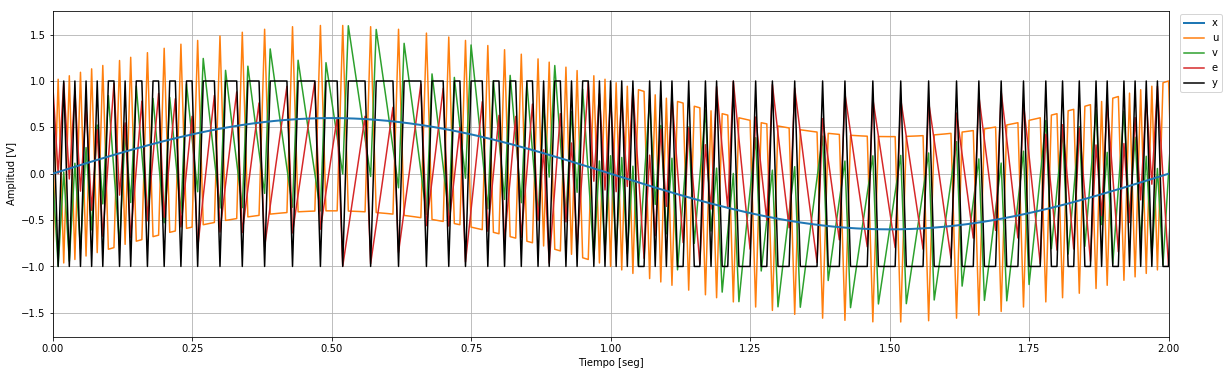

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(t,x,label='x',linewidth=2,zorder=10)
plt.plot(t,u,label='u')
#plt.plot(t,r,label='r')
plt.plot(t,v,label='v')
plt.plot(t,e,label='e')
plt.plot(t,y,label='y',color="k")
plt.xlabel("Tiempo [seg]")
plt.ylabel("Amplitud [V]")
plt.xlim(0,1/f_0)
plt.grid()
plt.legend(loc=(1.01,0.75))
plt.show()

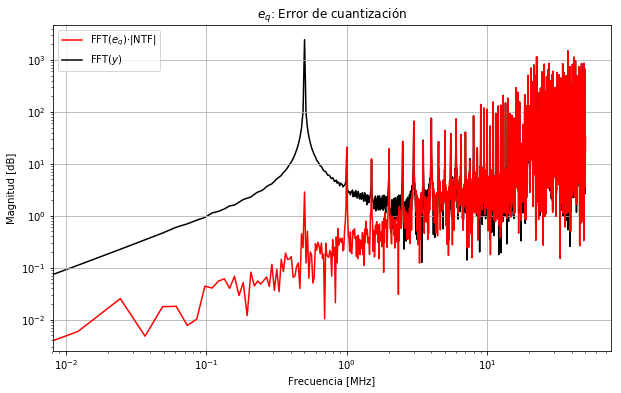

In [37]:
U = np.fft.fft(e)
freq = np.fft.fftfreq(t.shape[-1],d=T_s)
N = len(freq)
U = U[:N//2]
freqs = freq[:N//2] #frecuencias positivas
Ue = np.sqrt(U.real**2+U.imag**2) #valores absolutos

U = np.fft.fft(y)
freq = np.fft.fftfreq(t.shape[-1],d=T_s)
N = len(freq)
U = U[:N//2]
freqs = freq[:N//2] #frecuencias positivas
Uy = np.sqrt(U.real**2+U.imag**2) #valores absolutos

def ntf(f):
    return 1-np.exp(-1j*2*np.pi*f/f_s)

plt.figure(figsize=(10, 6))
plt.title("$e_q$: Error de cuantización") #$y$: Salida del cuantizador
plt.plot(freqs,Ue*np.abs(ntf(freqs)),label='FFT($e_q$)$\cdot$|NTF|',color='r')
#plt.plot(freqs, Ue,label='FFT($e_q$)',zorder=0,color="y")
plt.plot(freqs, Uy,label='FFT($y$)',zorder=1,color="k")
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('Magnitud [dB]')
plt.legend()